<a href="https://colab.research.google.com/github/IlyaTyagin/AGATHA-C-GP/blob/master/HW9/HW9_Ilya_Tyagin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW9 Ilya Tyagin

In [ ]:
import pandas as pd
import numpy as np
import pylab as pl
import random
from scipy import stats
from tqdm import tqdm
from collections import defaultdict
import pickle

from scipy import interpolate

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import glob
import pylab as pl
from PIL import Image

tqdm.pandas()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pl.rcParams['figure.figsize'] = (15, 10)

## Autoencoder

I'm using the simplest architecture, which was proposed for MNIST digits: https://github.com/fedhere/MLTSA22_FBianco/blob/main/CodeExamples/autoencoder_digits.ipynb

In [ ]:
all_autoenc_data = np.load(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/all_autoenc_data.npy'
)

In [ ]:
# we'll use the majority of our data for training
# and only 5% for test (just for the reference)

split_percent = 0.95

In [ ]:
split_idx = int(all_autoenc_data.shape[0]*split_percent)
x_train = all_autoenc_data[:split_idx]
x_test = all_autoenc_data[split_idx:]

x_train.shape, x_test.shape

((7436, 3006), (392, 3006))

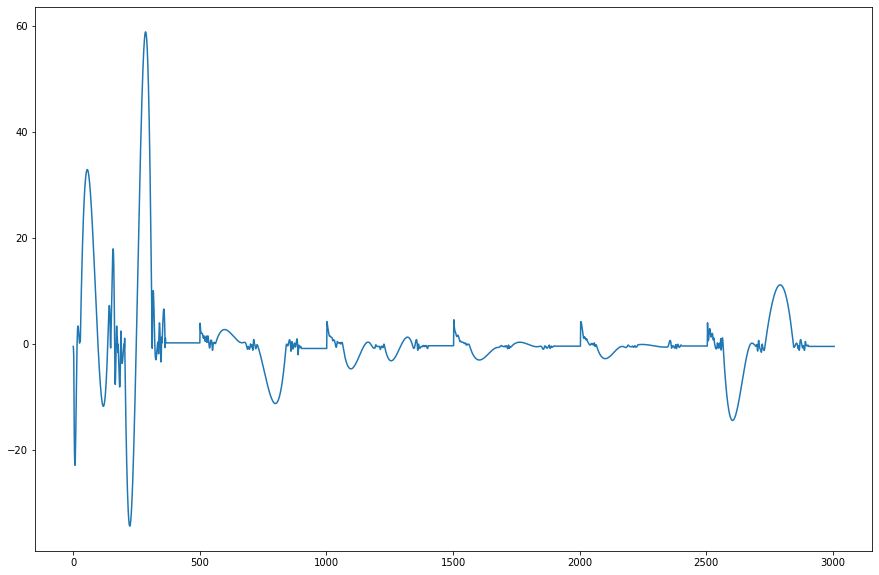

In [ ]:
plt.plot(x_train[400])

In [ ]:
ndim = all_autoenc_data.shape[1]
ndim

3006

In [ ]:
model_autoenc = Sequential()
## encoder
# input layer and the output size
model_autoenc.add(Dense(128, activation='relu', input_dim=ndim))
#compression layer
model_autoenc.add(Dense(64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
model_autoenc.add(Dense(128, activation='relu'))
#output layer, same size as input
model_autoenc.add(Dense(ndim, activation='linear'))

In [ ]:
model_autoenc.compile(optimizer="adadelta", loss="mean_squared_error")

In [ ]:
print(model_autoenc.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               384896    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 3006)              387774    
                                                                 
Total params: 789,246
Trainable params: 789,246
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_autoenc.optimizer.learning_rate = 0.1

In [ ]:
history_autoenc = model_autoenc.fit(x_train, x_train, 
                               validation_data=(x_test, x_test),
                               epochs=200, batch_size=100, verbose=1)

Epoch 1/200
75/75 [==============================] - 1s 8ms/step - loss: 107601.8047 - val_loss: 6851.0645
Epoch 2/200
75/75 [==============================] - 0s 6ms/step - loss: 106758.7344 - val_loss: 6694.9326
Epoch 3/200
75/75 [==============================] - 0s 6ms/step - loss: 106261.5234 - val_loss: 6397.1143
Epoch 4/200
75/75 [==============================] - 0s 6ms/step - loss: 105772.9453 - val_loss: 6333.9629
Epoch 5/200
75/75 [==============================] - 0s 6ms/step - loss: 105242.3203 - val_loss: 6281.0913
Epoch 6/200
75/75 [==============================] - 1s 8ms/step - loss: 104671.4062 - val_loss: 6246.3174
Epoch 7/200
75/75 [==============================] - 1s 8ms/step - loss: 104074.1641 - val_loss: 6208.9058
Epoch 8/200
75/75 [==============================] - 1s 7ms/step - loss: 103402.4844 - val_loss: 6171.4434
Epoch 9/200
75/75 [==============================] - 1s 8ms/step - loss: 102644.3281 - val_loss: 6124.7915
Epoch 10/200
75/75 [=================

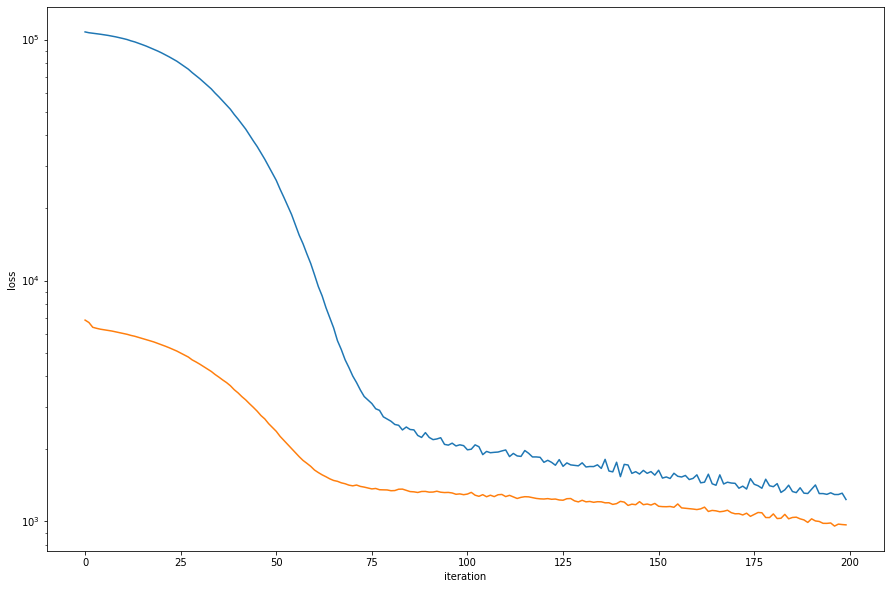

In [ ]:
pl.plot(np.array(history_autoenc.history['loss']))
pl.plot(np.array(history_autoenc.history['val_loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
pl.yscale('log')

Plot: Losses for train and validation over time (MSE). Log scale applied to show the the later stages at greater detail. After ~100-ish epoch we're entering the zone of very small improvements, but the loss was still going down. 

In [ ]:
x_train_pred = model_autoenc.predict(x_train)

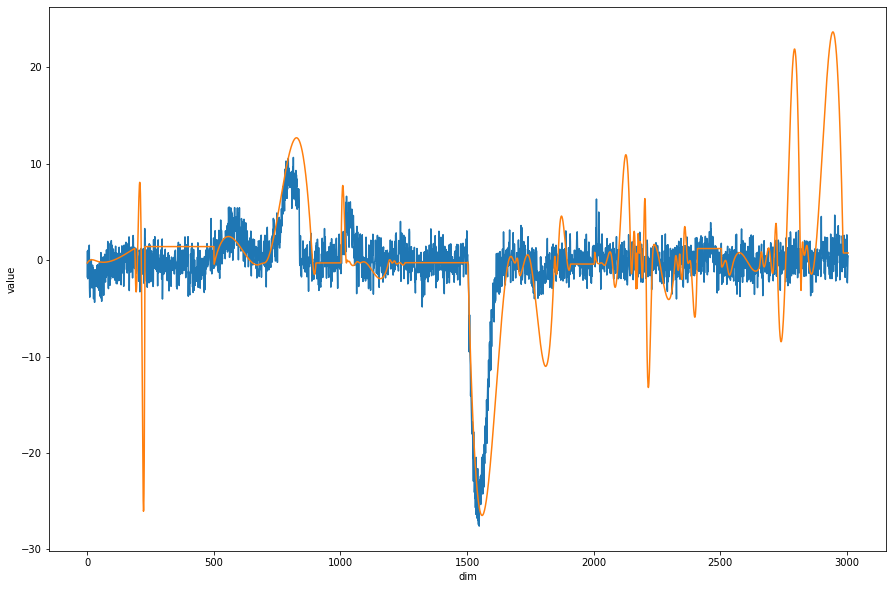

In [ ]:
idx = 3033
pl.plot(x_train_pred[idx])
pl.plot(x_train[idx])
pl.xlabel('dim')
pl.ylabel('value')
print()

Plot: original TS (6 concatenated bands (in orange) and it's reconstructed output). As we can see, some bands (in the middle) work much better than the ones at the beginning and end. And the overall result is rather noisy. Advances in autoencoder architecture are expected to bring some improvements to the result.

### Feature extraction

Here we're taking the hidden layer numbers for each sample, thus extract features from the trained autoencoder:

In [ ]:
from keras import backend as K
# input placeholder
inp = model_autoenc.input                   
# extract the bottle neck outputs
outputs = model_autoenc.layers[1].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])

In [ ]:
compressed_features = functors(np.concatenate([x_train, x_test]))

In [ ]:
np.concatenate([x_train, x_test]).shape

(7828, 3006)

In [ ]:
# we have 64 features for all samples

compressed_features[0].shape

(7828, 64)

In [ ]:
compressed_features[0]

array([[ 32.44364  ,  63.96016  ,  26.845545 , ...,   6.2820005,
          0.       ,  32.254894 ],
       [ 17.443123 ,  16.649073 ,   1.2970006, ...,   2.4258208,
         29.574484 ,   0.       ],
       [239.47148  , 171.59132  ,  62.960743 , ...,   0.       ,
         53.80349  , 116.893074 ],
       ...,
       [489.78888  , 346.67056  , 413.16638  , ...,  21.775856 ,
         98.225136 , 248.83293  ],
       [273.69278  , 528.46844  , 245.63077  , ..., 159.87344  ,
         46.097965 , 115.85296  ],
       [ 10.881871 ,  37.664005 ,  15.675756 , ...,  12.736168 ,
         31.437069 ,  26.03871  ]], dtype=float32)

In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df = pd.read_pickle(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df.pkl'
)

In [ ]:
all_ids_np = lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df.index.to_numpy()

In [ ]:
all_ids_list[:3]

array([615, 713, 730])

In [ ]:
compressed_features_np = compressed_features[0]

In [ ]:
np.save(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/compressed_features_np.npy',
    compressed_features_np
)
np.save(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/all_ids_np.npy',
    all_ids_np
)

## Classifier

As suggested in readme, random forest classifier was used. I also tried Logistic Regression, but the results were worse, so I sticked to RF.

In [ ]:
import seaborn as sn

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
all_ids_np = np.load(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/all_ids_np.npy',
)
compressed_features_np = np.load(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/compressed_features_np.npy',
)

In [ ]:
metadata = pd.read_csv(
    """https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz?download=1""", 
    compression='gzip'
    ).set_index('object_id')

In [ ]:
classes_array = metadata.loc[all_ids_list]['target'].to_numpy()

### Adding features from HW7

In [ ]:
allfeatures_hw7_df = pd.read_pickle(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW7/allfeatures.pkl'
)

In [ ]:
allfeatures_hw7_df

passband            0                                                      1  \
                 mean          std      skew  kurtosis    median        mean   
object_id                                                                      
615         -3.254554    83.944735  0.125827 -1.454426 -0.081184 -385.699911   
713         -2.720398     7.113509  0.254446 -1.027516 -0.053296   -1.019804   
730         -0.048080     1.828872  0.349431  0.359725  0.039740    0.141057   
745          1.797523     4.374445  1.980815  4.232286 -0.170538    5.717394   
1124         0.660948     2.360084 -0.324207  0.664903 -0.034136    4.634637   
...               ...          ...       ...       ...       ...         ...   
130739978    1.286655    15.998517  1.623297  3.827157 -0.046388   11.604012   
130755807   24.635243    79.713932  2.779088  6.214792 -0.276623    6.965825   
130762946   -0.282914    46.605187 -1.877398  3.701710  0.171062  -20.094296   
130772921    3.374208    14.420201  1.253611  0.602310 -0.363898   28.342250   
130779836  812.700937  2120.766511  3.013054  7.418233 -0.354338  725.169852   

passband                                               ...             4  \
                   std      skew   kurtosis    median  ...           std   
object_id                                              ...                 
615         601.787302  0.404755  -1.251198 -0.171576  ...    291.803449   
713           5.712334 -0.085494  -1.106890  0.080915  ...      6.406989   
730           1.807229  0.457635   0.771778  0.016918  ...     10.710344   
745          25.964659  6.817994  46.333887 -0.187678  ...     33.069053   
1124          8.107525  2.315295   5.496244 -0.432985  ...     26.865913   
...                ...       ...        ...       ...  ...           ...   
130739978    42.103636  3.274078   8.851832 -0.293677  ...     16.735430   
130755807    16.268582  2.549417   5.025328 -0.368264  ...    108.319727   
130762946    23.572412 -1.595460   2.763135  0.084014  ...     22.364118   
130772921    97.513710  2.842442   6.087819 -0.317331  ...     10.112169   
130779836  1197.557111  1.565742   0.772541 -0.536827  ...  11006.766106   

passband                                            5                         \
               skew   kurtosis    median         mean          std      skew   
object_id                                                                      
615        0.194883  -1.519722 -0.164502   -47.449847   294.779522  0.121948   
713       -0.062403  -1.191860  0.017023    -1.794175     7.094073  0.212294   
730        2.462542   5.385640 -0.311592     4.539396    13.332758  1.630520   
745        3.382600  12.445025 -0.362020    10.746138    26.060130  3.083716   
1124       3.802308  14.897216 -0.306424     6.896742    21.434627  3.560347   
...             ...        ...       ...          ...          ...       ...   
130739978  0.411283   0.537647 -0.029879    20.073462    97.602719  3.825390   
130755807  2.341093   3.831769 -0.337950     3.528390    38.849765  1.082769   
130762946  0.579885  -0.298582 -0.108920    -9.838345    48.309960  1.458295   
130772921 -0.334336  -0.642642  0.085127     7.671389    44.169662  2.515357   
130779836  4.221177  17.012896 -0.315443  4151.358875  8687.101173  2.274800   

passband                           decl  
            kurtosis    median           
object_id                                
615        -1.559937 -0.130311 -61.9438  
713        -0.832902 -0.095134 -27.7844  
730         3.125970 -0.151253  -6.5796  
745        10.952063 -0.309679 -45.5867  
1124       13.095559 -0.231739 -63.8237  
...              ...       ...      ...  
130739978  17.651123 -0.092976 -14.9403  
130755807   2.246605 -0.110052 -62.6967  
130762946   4.501540 -0.026980 -55.6821  
130772921   9.593440 -0.108513 -35.5018  
130779836   3.629547 -0.427486 -17.4263  

[7848 rows x 31 columns]

In [ ]:
allfeatures_hw7_np = allfeatures_hw7_df.loc[all_ids_list].to_numpy()
allfeatures_hw7_np.shape

(7828, 31)

In [ ]:
all_features_concat_np = np.concatenate(
    [allfeatures_hw7_np, compressed_features_np],
    axis=1
)
all_features_concat_np.shape

(7828, 95)

### Ablation study: curated features (C) vs Autoencoder (A) vs both (CA)

Here we compare 3 sets of features and check which set is the best

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
idx_train, idx_test = train_test_split(
    np.array(range(len(classes_array))), 
    test_size=0.33, 
    random_state=42
)

In [ ]:
len(idx_train), len(idx_test)

(5244, 2584)

In [ ]:
features_dict = {
    'C': allfeatures_hw7_np,
    'A': compressed_features_np,
    'CA': all_features_concat_np,
}
results_dict = dict()

In [ ]:
y_train = classes_array[idx_train]
y_test = classes_array[idx_test]

for mode in tqdm(features_dict):
  clf = RandomForestClassifier(random_state=0)
  X_train = features_dict[mode][idx_train]
  X_test = features_dict[mode][idx_test]
  clf.fit(X_train, y_train)

  y_test_pred = clf.predict(X_test)

  results_dict[mode] = {
      'accuracy': clf.score(X_test, y_test),
      'class_matrix': confusion_matrix(
          y_true=y_test,
          y_pred=clf.predict(X_test),
      ),
      'classes': clf.classes_,
  }

100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


features type: C
accuracy: 0.6617647058823529


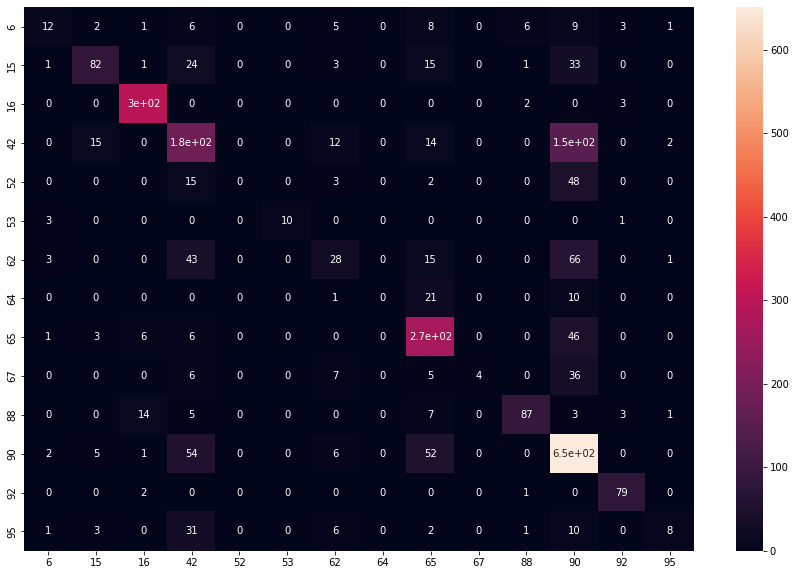

features type: A
accuracy: 0.2801857585139319


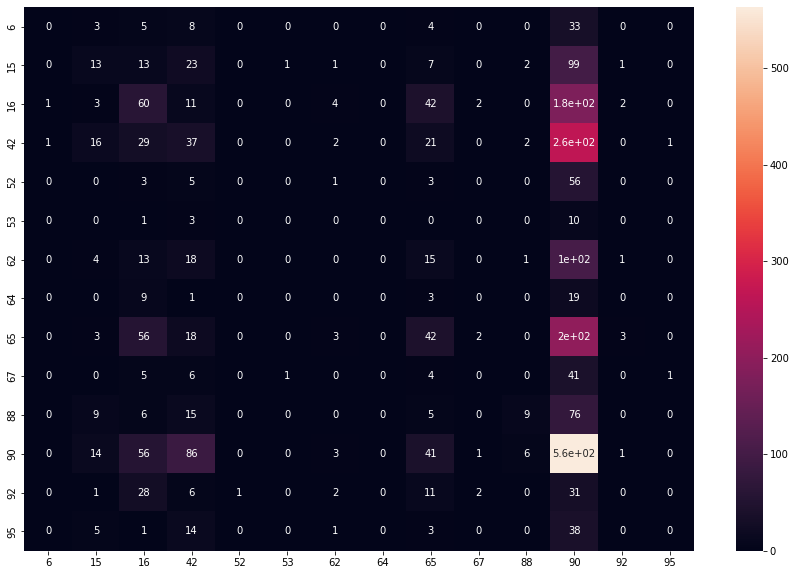

features type: CA
accuracy: 0.6501547987616099


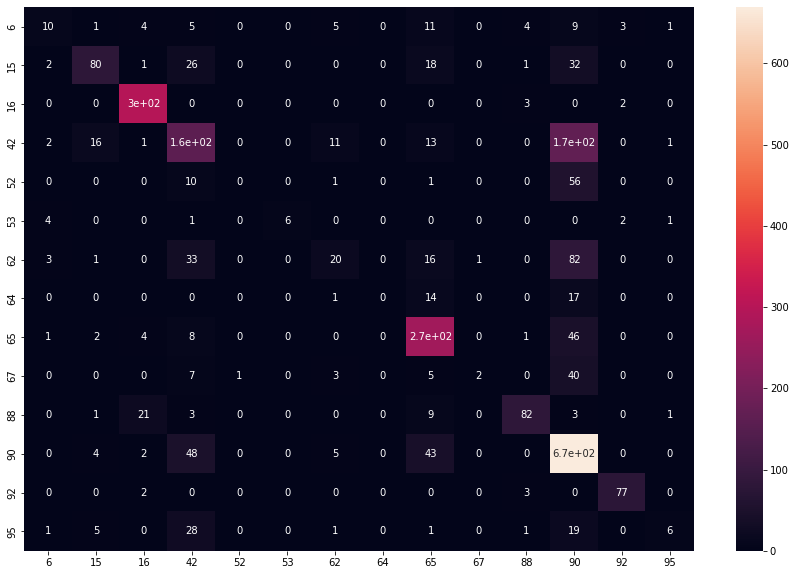

In [ ]:
for mode in results_dict:
  print(f"features type: {mode}")
  print(f"accuracy: {results_dict[mode]['accuracy']}")
  cm_df = pd.DataFrame(
    results_dict[mode]['class_matrix'], 
    index = results_dict[mode]['classes'],
    columns = results_dict[mode]['classes'],
  )
  sn.heatmap(cm_df, annot=True)
  pl.show()

Plots: classification matrices for 3 RF classifiers trained on the same data with different features. The best accuracy (0.66) was demonstrated by the one trained with only curated features we extracted in HW7, adding AE features made the result a bit worse (0.65) and AE features solely do not provide good results. We also need to keep in mind that accuracy is probably not the best way to evaluate the classifier for this case (bacause we have a significant class imbalance):

In [ ]:
metadata['target'].value_counts()

90    2313
42    1193
65     981
16     924
15     495
62     484
88     370
92     239
67     208
52     183
95     175
6      151
64     102
53      30
Name: target, dtype: int64

So, to conclude, there are some improvements we could make to get better results and we will definitely keep the experience we got in HW8/9 in mind when we work on our project!